In [7]:
import time
import numpy as np
import torch

from sbi import utils as utils
from sbi import analysis as analysis
from cost_aware_snpe_c import CostAwareSNPE_C
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from simulators import bernoulli_sir

from hydra import compose, initialize
import hydra

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt
import seaborn as sns

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    'font.family' : 'times',
    'font.size' : 14.0,
    'lines.linewidth' : 2,
    'lines.antialiased' : True,
    'axes.facecolor': 'fdfdfd',
    'axes.edgecolor': '777777',
    'axes.linewidth' : 1,
    'axes.titlesize' : 'medium',
    'axes.labelsize' : 'medium',
    'axes.axisbelow' : True,
    'xtick.major.size'     : 0,      # major tick size in points
    'xtick.minor.size'     : 0,      # minor tick size in points
    'xtick.major.pad'      : 6,      # distance to major tick label in points
    'xtick.minor.pad'      : 6,      # distance to the minor tick label in points
    'xtick.color'          : '333333', # color of the tick labels
    'xtick.labelsize'      : 'medium', # fontsize of the tick labels
    'xtick.direction'      : 'in',     # direction: in or out
    'ytick.major.size'     : 0,      # major tick size in points
    'ytick.minor.size'     : 0,      # minor tick size in points
    'ytick.major.pad'      : 6,      # distance to major tick label in points
    'ytick.minor.pad'      : 6,      # distance to the minor tick label in points
    'ytick.color'          : '333333', # color of the tick labels
    'ytick.labelsize'      : 'medium', # fontsize of the tick labels
    'ytick.direction'      : 'in',     # direction: in or out
    'axes.grid' : False,
    'grid.alpha' : 0.3,
    'grid.linewidth' : 1,
    'legend.fancybox' : True,
    'legend.fontsize' : 'Small',
    'figure.figsize' : (2.5, 2.5),
    'figure.facecolor' : '1.0',
    'figure.edgecolor' : '0.5',
    'hatch.linewidth' : 0.1,
    'text.usetex' : False
    })

color_map = {'green': '#009E60', 'orange': '#C04000',
              'blue': '#00416A', 'black':'#3A3B3C',
              'purple': '#843B62', 'red': '#C41E3A'}


plt.rcParams['text.latex.preamble'] = r'\usepackage{serif}'

In [3]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2

    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

In [4]:
def calc_acc_prob(gp, likelihood, theta, prior_start, k):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        cost = likelihood(model(theta)).mean

        lower_cost = likelihood(model(prior_start)).mean
    return (lower_cost ** k) / (cost**k)

class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Bernoulli SIR

In [9]:
bern_sir = bernoulli_sir.BernSIR()

## data generation

In [ ]:
# DON'T NEED TO RUN
N = 50000

bern_sir_theta_npe_large = bern_sir.sample_theta([N]).reshape(-1, bern_sir.theta_dim)
bern_sir_x_npe_large = torch.empty([N, bern_sir.x_dim])
for i in range(N):
    bern_sir_x_npe_large[i, :] = bern_sir(bern_sir_theta_npe_large[i])

torch.save(bern_sir_x_npe_large, "data/bern_sir_x_npe_large.pt")
torch.save(bern_sir_theta_npe_large, "data/bern_sir_theta_npe_large.pt")

In [11]:
# Use triton to generate data
N = 50000

bern_sir_theta_npe_large = bern_sir.sample_theta([N]).reshape(-1, bern_sir.theta_dim)
bern_sir_x_npe_large = torch.empty([N, bern_sir.x_dim])
for i in range(100):
    bern_sir_x_npe_large[500*i: 500*(i+1), :] = torch.load(f"data/bern_sir_large/bern_sir_x_npe_large_{i+1}.pt")
    bern_sir_theta_npe_large[500*i: 500*(i+1), :] = torch.load(f"data/bern_sir_large/bern_sir_theta_npe_large_{i+1}.pt")

torch.save(bern_sir_x_npe_large, "data/bern_sir_x_npe_large.pt")
torch.save(bern_sir_theta_npe_large, "data/bern_sir_theta_npe_large.pt")

In [91]:
# DON'T NEED TO RUN
bern_sir_obs_theta = torch.tensor([0.5, 0.5, 0.5])
bern_sir_obs_x = bern_sir(bern_sir_obs_theta)
bern_sir_obs_x

tensor([8.0000e+00, 5.0000e+00, 7.0000e+00, 5.0000e+00, 5.0000e+00, 9.0000e+00,
        8.0000e+00, 1.1000e+01, 1.3000e+01, 2.9000e+01, 1.0000e+02, 5.4006e+06])

In [56]:
# DON'T NEED TO RUN
torch.save(bern_sir_obs_x, "data/bern_sir_obs_x.pt")
torch.save(bern_sir_obs_theta, "data/bern_sir_obs_theta.pt")

## Load data

In [59]:
bern_sir_x_npe_large = torch.load("data/bern_sir_x_npe_large.pt")
bern_sir_theta_npe_large = torch.load("data/bern_sir_theta_npe_large.pt")

bern_sir_obs_x = torch.load("data/bern_sir_obs_x.pt")
bern_sir_obs_theta = torch.load("data/bern_sir_obs_theta.pt")

## Fit GP

In [13]:
# for gp
n_train_pair = 200
X = bern_sir_theta_npe_large[:n_train_pair]
n_rep = 20

times_train = torch.zeros(n_train_pair)

for i in range(n_train_pair):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(bern_sir_theta_npe_large[i])
    et = time.time()
    times_train[i] = et - st

In [14]:
# save GP training samples
torch.save(X, "data/bern_sir_gp_x.pt")
torch.save(times_train, "data/bern_sir_gp_y.pt")

In [17]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 500
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X.float())
    loss = -mll(output, times_train)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')


torch.save({
    'model_state_dict': model.state_dict(),
    'likelihood_state_dict': likelihood.state_dict()
}, 'data/bern_sir_gp.pth')


Iter 1/500 - Loss: 60.69684600830078
Iter 2/500 - Loss: 53.76813507080078
Iter 3/500 - Loss: 47.784881591796875
Iter 4/500 - Loss: 42.6547737121582
Iter 5/500 - Loss: 38.284088134765625
Iter 6/500 - Loss: 34.584957122802734
Iter 7/500 - Loss: 31.478029251098633
Iter 8/500 - Loss: 28.890363693237305
Iter 9/500 - Loss: 26.751747131347656
Iter 10/500 - Loss: 24.992921829223633
Iter 11/500 - Loss: 23.5472412109375
Iter 12/500 - Loss: 22.353958129882812
Iter 13/500 - Loss: 21.360597610473633
Iter 14/500 - Loss: 20.523448944091797
Iter 15/500 - Loss: 19.806682586669922
Iter 16/500 - Loss: 19.181095123291016
Iter 17/500 - Loss: 18.623123168945312
Iter 18/500 - Loss: 18.114093780517578
Iter 19/500 - Loss: 17.63981819152832
Iter 20/500 - Loss: 17.19000816345215
Iter 21/500 - Loss: 16.75786018371582
Iter 22/500 - Loss: 16.339391708374023
Iter 23/500 - Loss: 15.932868957519531
Iter 24/500 - Loss: 15.538155555725098
Iter 25/500 - Loss: 15.156119346618652
Iter 26/500 - Loss: 14.788187026977539
Iter

Iter 235/500 - Loss: 5.885510444641113
Iter 236/500 - Loss: 5.8777174949646
Iter 237/500 - Loss: 5.869976997375488
Iter 238/500 - Loss: 5.862293243408203
Iter 239/500 - Loss: 5.8546600341796875
Iter 240/500 - Loss: 5.847080230712891
Iter 241/500 - Loss: 5.8395538330078125
Iter 242/500 - Loss: 5.832075595855713
Iter 243/500 - Loss: 5.824650764465332
Iter 244/500 - Loss: 5.8172736167907715
Iter 245/500 - Loss: 5.809950351715088
Iter 246/500 - Loss: 5.802673816680908
Iter 247/500 - Loss: 5.795445442199707
Iter 248/500 - Loss: 5.788266181945801
Iter 249/500 - Loss: 5.781134128570557
Iter 250/500 - Loss: 5.774052619934082
Iter 251/500 - Loss: 5.76701545715332
Iter 252/500 - Loss: 5.760021209716797
Iter 253/500 - Loss: 5.753076076507568
Iter 254/500 - Loss: 5.746176242828369
Iter 255/500 - Loss: 5.739322662353516
Iter 256/500 - Loss: 5.732512950897217
Iter 257/500 - Loss: 5.725744247436523
Iter 258/500 - Loss: 5.719020843505859
Iter 259/500 - Loss: 5.712340831756592
Iter 260/500 - Loss: 5.70

In [20]:
model.eval()
likelihood.eval()

N = 100

beta = torch.linspace(0.1, 1, N)
beta_fixed = 0.5


gamma_fixed = 0.5
gamma = torch.linspace(0.1, 1, N)

p = torch.linspace(0.1, 1, N)
p_fixed = 0.5

beta_combined = beta_fixed * torch.ones_like(beta)
gamma_combined = gamma_fixed * torch.ones_like(gamma)
p_combined = p_fixed * torch.ones_like(p)

combination_beta = torch.stack((beta, gamma_combined, p_combined), dim=1)
combination_gamma = torch.stack((beta_combined, gamma, p_combined), dim=1)
combination_p = torch.stack((beta_combined, gamma_combined, p), dim=1)

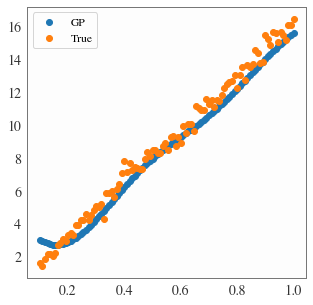

In [21]:
times_vs_beta = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(combination_beta[i])
    et = time.time()
    times_vs_beta[i] = (et - st)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_beta)).mean

plt.figure(figsize=[5,5])
plt.scatter(beta, observed_pred, label="GP")
plt.scatter(beta, times_vs_beta, label="True")
plt.legend()
plt.show()

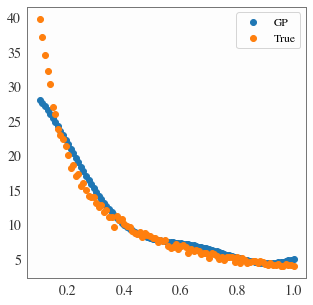

In [22]:
times_vs_gamma = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(combination_gamma[i])
    et = time.time()
    times_vs_gamma[i] = (et - st)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_gamma)).mean

plt.figure(figsize=[5,5])
plt.scatter(gamma, observed_pred, label="GP")
plt.scatter(gamma, times_vs_gamma, label="True")
plt.legend()
plt.show()

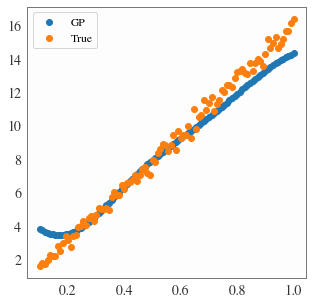

In [23]:
times_vs_p = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(combination_p[i])
    et = time.time()
    times_vs_p[i] = (et - st)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_p)).mean

plt.figure(figsize=[5,5])
plt.scatter(p, observed_pred, label="GP")
plt.scatter(p, times_vs_p, label="True")
plt.legend()
plt.show()

In [109]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(torch.tensor([1.0, 0.1, 1.0]).reshape(1, -1))).mean
    
print(observed_pred)

tensor([80.1732])


In [35]:
state_dicts = torch.load('data/bern_sir_gp.pth')

X = torch.load("data/bern_sir_gp_x.pt")
times_train = torch.load("data/bern_sir_gp_y.pt")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

prior_start = torch.tensor([0.1, 1.0, 0.001]).reshape(-1, 3)
k = 2

num_sim = 5000
theta_tilde = torch.zeros([num_sim, 3])
count = 0
while count < num_sim:
    theta = bern_sir.sample_theta([1]).reshape(-1, 3)
    if calc_acc_prob(model, likelihood, theta, prior_start, k) > torch.rand(1):
        theta_tilde[count] = theta.reshape(-1)
        count += 1

In [36]:
w = likelihood(model(theta_tilde)).mean.detach() ** k

In [37]:
theta_prior = bern_sir.sample_theta([5000]).reshape(-1, 3)

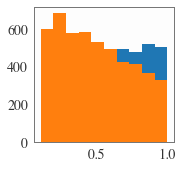

In [40]:
plt.hist(theta_prior.detach().numpy()[:, 0], bins=10)
plt.hist(theta_tilde.detach().numpy()[:, 0], bins=10)
plt.show()

## Train

In [41]:
# DON'T NEED TO RUN
bern_sir_inference_npe_large = SNPE_C()
bern_sir_nn_npe_large = bern_sir_inference_npe_large.append_simulations(
    bern_sir_theta_npe_large, bern_sir_x_npe_large).train()

 Neural network successfully converged after 73 epochs.

In [92]:
# DON'T NEED TO RUN
prior, *_ = process_prior(bern_sir.prior)
bern_sir_post_npe_large = bern_sir_inference_npe_large.build_posterior(bern_sir_nn_npe_large, prior=prior)
bern_sir_samples_npe_large = bern_sir_post_npe_large.sample((1000,), x=bern_sir_obs_x)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [93]:
# DON'T NEED TO RUN
torch.save(bern_sir_samples_npe_large, "data/bern_sir_post_reference.pt")

In [94]:
bern_sir_post_reference = torch.load("data/bern_sir_post_reference.pt")

In [101]:
k = 1.0
n_run = 50
mmd_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 3])
cost_npe = torch.zeros([n_run])
mmd_canpe = torch.zeros([n_run])
posterior_samples_canpe = torch.zeros([n_run, 1000, 3])
cost_canpe = torch.zeros([n_run])

cost_saved = torch.zeros([n_run])


for i in range(n_run):
    checkpoint_path = f"sims/bern_sir/{k}/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    posterior_npe = checkpoint["posterior_npe"]
    posterior_canpe = checkpoint["posterior_canpe"]
    

#     posterior_samples_npe[i] = checkpoint["posterior_samples_npe"]
#     posterior_samples_canpe[i] = checkpoint["posterior_samples_canpe"]
    
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)
    posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)
    
    mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], bern_sir_post_reference, lengthscale=median_heuristic(bern_sir_post_reference))
    mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], bern_sir_post_reference, lengthscale=median_heuristic(bern_sir_post_reference))
    cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
    cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
    
    cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
    
mmd_npe = mmd_npe.detach().numpy() 
mmd_npe_mean = np.mean(mmd_npe)
mmd_npe_std = np.std(mmd_npe)

mmd_canpe = mmd_canpe.detach().numpy() 
mmd_canpe_mean = np.mean(mmd_canpe)
mmd_canpe_std = np.std(mmd_canpe)

cost_npe = cost_npe.detach().numpy() 
cost_npe_mean = np.mean(cost_npe)
cost_npe_std = np.std(cost_npe)

cost_canpe = cost_canpe.detach().numpy() 
cost_canpe_mean = np.mean(cost_canpe)
cost_canpe_std = np.std(cost_canpe)

cost_saved = cost_saved.detach().numpy()
cost_saved_mean = np.mean(cost_saved)
cost_saved_std = np.std(cost_saved)

print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")
print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")

print(f"NPE cost mean {cost_npe_mean:.2f} (std {cost_npe_std:.2f})")
print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")

print(f"Cost saved: {cost_saved_mean}(std {cost_saved_std})")

NPE MMD mean 0.01 (std 0.00)
CA-NPE MMD mean 0.01 (std 0.00)
NPE cost mean 23189.70 (std 2171.07)
CA-NPE cost mean 14632.17 (std 1153.01)
Cost saved: 0.36650246381759644(std 0.04289127513766289)


In [103]:
k = 0.5
n_run = 50
mmd_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 3])
cost_npe = torch.zeros([n_run])
mmd_canpe = torch.zeros([n_run])
posterior_samples_canpe = torch.zeros([n_run, 1000, 3])
cost_canpe = torch.zeros([n_run])

cost_saved = torch.zeros([n_run])


for i in range(n_run):
    checkpoint_path = f"sims/bern_sir/{k}/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    posterior_npe = checkpoint["posterior_npe"]
    posterior_canpe = checkpoint["posterior_canpe"]
    

#     posterior_samples_npe[i] = checkpoint["posterior_samples_npe"]
#     posterior_samples_canpe[i] = checkpoint["posterior_samples_canpe"]
    
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)
    posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)
    
    mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], bern_sir_post_reference, lengthscale=median_heuristic(bern_sir_post_reference))
    mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], bern_sir_post_reference, lengthscale=median_heuristic(bern_sir_post_reference))
    cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
    cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
    
    cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
    
mmd_npe = mmd_npe.detach().numpy() 
mmd_npe_mean = np.mean(mmd_npe)
mmd_npe_std = np.std(mmd_npe)

mmd_canpe = mmd_canpe.detach().numpy() 
mmd_canpe_mean = np.mean(mmd_canpe)
mmd_canpe_std = np.std(mmd_canpe)

cost_npe = cost_npe.detach().numpy() 
cost_npe_mean = np.mean(cost_npe)
cost_npe_std = np.std(cost_npe)

cost_canpe = cost_canpe.detach().numpy() 
cost_canpe_mean = np.mean(cost_canpe)
cost_canpe_std = np.std(cost_canpe)

cost_saved = cost_saved.detach().numpy()
cost_saved_mean = np.mean(cost_saved)
cost_saved_std = np.std(cost_saved)

print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")
print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")

print(f"NPE cost mean {cost_npe_mean:.2f} (std {cost_npe_std:.2f})")
print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")

print(f"Cost saved: {cost_saved_mean}(std {cost_saved_std})")

FileNotFoundError: [Errno 2] No such file or directory: 'sims/bern_sir/0.5/8/ckpt.tar'

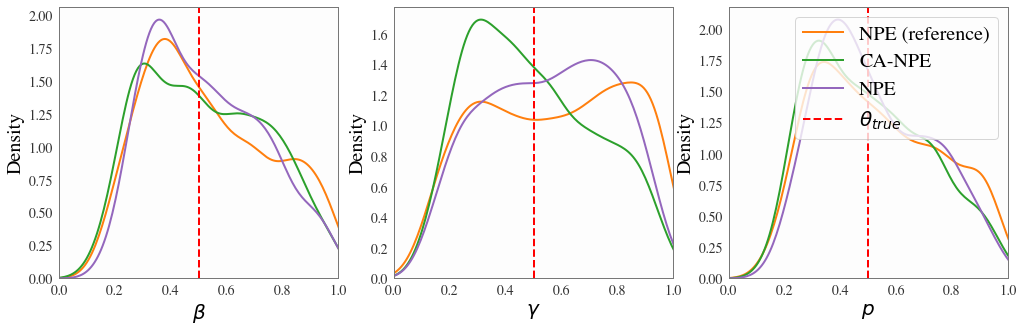

In [97]:
seed = 1
plt.figure(figsize=[17,5])
plt.subplot(1, 3, 1)
plt.xlim(0, 1)
sns.kdeplot(bern_sir_post_reference[:,0], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,0], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=bern_sir_obs_theta.detach().numpy()[0], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')

plt.xlabel("$\\beta$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
# plt.title(f"MMD:{mmd[seed]:.2f}")

plt.subplot(1, 3, 2)
plt.xlim(0, 1)
sns.kdeplot(bern_sir_post_reference[:,1], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,1], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,1], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=bern_sir_obs_theta.detach().numpy()[1], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.xlabel("$\\gamma$", fontsize = 20)
plt.ylabel("Density", fontsize=20)

plt.subplot(1, 3, 3)
plt.xlim(0, 1)
sns.kdeplot(bern_sir_post_reference[:,2], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,2], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,2], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=bern_sir_obs_theta.detach().numpy()[2], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.legend(fontsize=20, loc=1)
plt.xlabel("$p$", fontsize = 20)
plt.ylabel("Density", fontsize=20)

plt.show()

# Cost plot

In [ ]:
N = 20
p = torch.linspace(0.1, 1, N)
beta_fixed = 0.5
gamma_fixed = 0.5

n_rep = 20
times_vs_gamma = torch.zeros(N)
for i in range(N):
    print("progress: ", i)
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(beta_fixed, gamma_fixed, p[i], device=torch.device('cpu'))
    et = time.time()
    times_vs_gamma[i] = (et - st) / n_rep

print(times_vs_gamma)

In [ ]:
N = 20

beta = torch.linspace(0.1, 1, N)
beta_fixed = 0.5


gamma_fixed = 0.5
gamma = torch.linspace(0.1, 1, N)

p = torch.linspace(0.1, 1, N)
p_fixed = 0.5

beta_combined = beta_fixed * torch.ones_like(beta)
gamma_combined = gamma_fixed * torch.ones_like(gamma)
p_combined = p_fixed * torch.ones_like(p)

combination_beta = torch.stack((beta, gamma_combined, p_combined), dim=1)
combination_gamma = torch.stack((beta_combined, gamma, p_combined), dim=1)
combination_p = torch.stack((beta_combined, gamma_combined, p), dim=1)

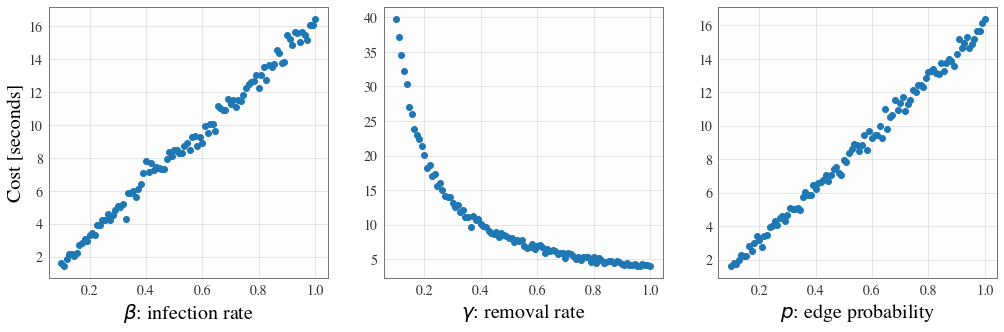

In [128]:
plt.figure(figsize=[17,5])
# plt.suptitle("     Bernoulli SIR", fontsize=20)

plt.subplot(1, 3, 1)
plt.scatter(beta, times_vs_beta)

plt.xlabel("$\\beta$: infection rate", fontsize=20)
plt.ylabel("Cost [seconds]", fontsize=20)
plt.grid()

plt.subplot(1, 3, 2)
plt.scatter(gamma, times_vs_gamma)

plt.xlabel("$\\gamma$: removal rate", fontsize=20)

plt.grid()

plt.subplot(1, 3, 3)
plt.scatter(p, times_vs_p)

plt.xlabel("$p$: edge probability", fontsize=20)

plt.grid()

plt.savefig("plot_cost_bern_sir.pdf")
plt.show()